In [197]:
import pandas as pd


In [198]:
df = pd.read_csv('data/dataset.csv')
train_df = df[(df['EventTime'] <= '2021-02-07')]
test_df = df[(df['EventTime'] > '2021-02-07')]
train_df

,EventTime,Measure,Class
0,2020-08-17 18:30:00,269,NaN
1,2020-08-17 18:40:00,380,NaN
2,2020-08-17 18:50:00,386,NaN
3,2020-08-17 19:00:00,376,NaN
4,2020-08-17 19:10:00,374,NaN
...,...,...,...
24880,2021-02-06 23:10:00,511,NaN
24881,2021-02-06 23:20:00,507,NaN
24882,2021-02-06 23:30:00,513,NaN
24883,2021-02-06 23:40:00,506,NaN


In [199]:
def processing_steps(df, window=10, feature_engineering=True):
    # process target feature
    df['Class'] = df['Class'].replace("S", 1)
    df['Class'] = df['Class'].fillna(0)
    if feature_engineering:
        # convert the time to a more usable format (from testing time does not seem to be a useful metric)
        df['EventTime'] = pd.to_datetime(df['EventTime'])
        df['weekday'] = df['EventTime'].dt.weekday
        df['hour'] = df['EventTime'].dt.hour
        df['minute'] = df['EventTime'].dt.minute

        # add in a time element
        df['rolling_average'] = df['Measure'].rolling(window=window).mean()
        df['diff_mean'] = df['Measure'] - df['rolling_average']
        for i in range(1, window):
            df[f'lag_{i}'] = df['Measure'].shift(i)
            df[f'percent_change_{i}'] = df['Measure'].pct_change()
            df[f'diff_lag_{i}'] = df['Measure'] - df[f'lag_{i}']


        # technically this is losing the first window elements, but this demonstrates the idea (to compensate you either need to read in the test set and split again or you use a model that can handle nans)
        df = df.dropna()
    df = df.drop('EventTime', axis=1)

    y = df["Class"]
    X = df.drop("Class", axis=1)
    return X, y

In [200]:
feature_engineering = True
X_train, y_train = processing_steps(train_df.copy(), feature_engineering=feature_engineering)
X_test, y_test = processing_steps(test_df.copy(), feature_engineering=feature_engineering)


In [201]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

model = RandomForestClassifier()
# model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [202]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, \
    roc_auc_score, confusion_matrix


def metrics(y_test, y_pred):
    print(f'f1 score = {f1_score(y_test, y_pred)}')
    print(f'balanced accuracy = {balanced_accuracy_score(y_test, y_pred)}')
    print(f'accuracy = {accuracy_score(y_test, y_pred)}')
    print(f'precision = {precision_score(y_test, y_pred)}')
    print(f'recall = {recall_score(y_test, y_pred)}')
    print(f'roc = {roc_auc_score(y_test, y_pred)}')

    CM = confusion_matrix(y_test, y_pred)
    print(f'confusion_matrix \n{CM}')


metrics(y_test, y_pred)
# basically there is extreme imbalance, where with 28 anomalies are easy to identify, so the model only predicts them when completely certain

f1 score = 0.5128205128205129
balanced accuracy = 0.678509616233686
accuracy = 0.9976592337070346
precision = 0.9090909090909091
recall = 0.35714285714285715
roc = 0.678509616233686
confusion_matrix 
[[8088    1]
 [  18   10]]


In [203]:
y_pred_prob = model.predict_proba(X_test)[:, 0]


0.07280389594334458


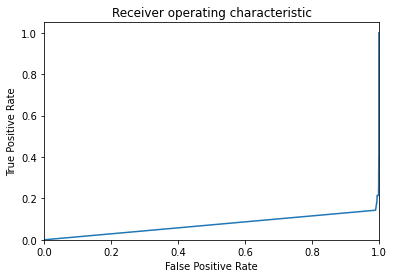

In [204]:
# plotting the ROC curve to get an indication of the threshold
# there is a linear relationship where you can balance to let it more normal cases in exchange for letting in more false positives
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob)
    roc_auc[i] = auc(fpr[i], tpr[i])
print(roc_auc_score(y_test, y_pred_prob))

plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [205]:
import numpy as np

# if detecting the outliers are really important, you can add in a few false positives here (based on business requirements you can adjust the acceptable threshold)
new_pred = np.where(y_pred_prob < .99, 1, 0)
metrics(y_test, new_pred)

f1 score = 0.4380952380952381
balanced accuracy = 0.9073764194761846
accuracy = 0.9927313046692128
precision = 0.2987012987012987
recall = 0.8214285714285714
roc = 0.9073764194761846
confusion_matrix 
[[8035   54]
 [   5   23]]
